In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

In [4]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [5]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [6]:
def innerProduct(x, y):
    result = tf.reduce_sum(tf.multiply(x, y))
    return result

In [7]:
def compute_step_size(n_omega, grad):
    result = -innerProduct(n_omega,grad)/(innerProduct(n_omega, n_omega))
    return result

In [8]:
def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt1"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

In [9]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [10]:
observed_ratio = 0.4
x_true_img = np.array(x_true_org.get_data())
mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])

x_init = copy.deepcopy(x_train)
#shape = (1, 53, 63, 63, 1)
#x_init_tf = t3f.random_tensor(shape, tt_rank=63)

ground_truth = copy.deepcopy(x_true_img)
a_omega = copy.deepcopy(ground_truth)
a_omega[mask_indices==0] = 0.0

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0

In [11]:
ten_ones = np.ones_like(mask_indices)


In [12]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print norm_sparse_observation

47395410.0


In [13]:
mask_indices_tf = t3f.to_tt_tensor(mask_indices.astype('float32'), max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [14]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [15]:
x_miss = image.index_img(x_miss_img,1)

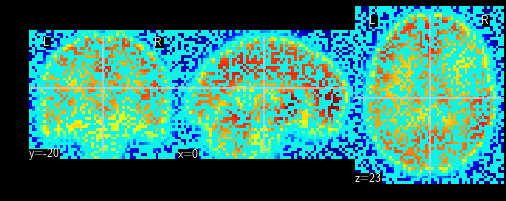

In [16]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [17]:
images_folder = "/work/scratch/tt1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/missing_ratio_60.00.png')
Called from mrd


In [18]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [19]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [20]:
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = ground_truth * sparsity_mask

In [21]:
#sparsity_mask = t3f.get_variable('sparsity_mask', initializer=mask_indices_tf, trainable=False)
#sparsity_mask = t3f.cast(sparsity_mask, tf.float32)
#sparse_observation_tf = t3f.to_tt_tensor(sparse_observation, max_tt_rank=63)
#sparse_observation_tf3 = t3f.get_variable('sparse_observation_tf', initializer=sparse_observation_tf, trainable=False)

In [22]:
x_train_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [23]:
normAOmegavar = tf.get_variable('normAOmega', initializer=norm_sparse_observation, trainable=False)

In [24]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [25]:
X_new = t3f.get_variable('X_new', initializer=x_train_tf)

In [26]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [27]:
def train_it_rel_cost(cost_hist, k):
    res = np.abs(cost_hist[k] - cost_hist[k-1])/np.abs(cost_hist[k])
    return res

In [28]:
counter = tf.get_variable('counter', initializer=0)

In [29]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [30]:
tt_zeros = initializers.tensor_zeros([53, 63, 46, 144])

In [31]:
#eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=tt_zeros)
#grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=tt_zeros)

In [32]:
eta_old = tf.get_variable('eta_old', shape = (53, 63, 46, 144), validate_shape=False)
grad_old = tf.get_variable('grad_old', shape = (53, 63, 46, 144), validate_shape=False)

In [33]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [34]:


def gradient(x):
    return np.multiply(x,mask_indices) - a_omega
    
def cost_func(x):
    return 0.5*(np.linalg.norm(np.multiply(x,mask_indices)-a_omega)** 2)

def find_step_size(x,g,d, old_cost):
    step_size = optimize.line_search(cost_func,gradient,x,d,gfk=None, old_fval=old_cost)

In [35]:
# Algorithm
#grad_full = (t3f.full(X)*t3f.full(sparse_observation_tf3) - t3f.full(sparse_observation_tf3))
#counter_step = tf.assign(counter, counter + 1)

#grad_trans = t3f.riemannian.project(grad_t3f_old, X)
#eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
#grad_full = sparsity_mask * t3f.full(X) - sparse_observation
#grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

#loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
#gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

#riemannian_grad = t3f.riemannian.project(grad_t3f, X)


#eta_omega = sparsity_mask * t3f.full(-riemannian_grad)
#alpha = compute_step_size(eta_omega, grad_full)



#riemannian_grad_norm = t3f.flat_inner(riemannian_grad, riemannian_grad)



#rel_error1 = relative_error1(t3f.full(X), t3f.full(sparse_observation))




In [36]:
eps = 1e-5
epsilon_train=1e-5

In [37]:
#print grad_full

In [38]:
#print grad_t3f

In [39]:
print eps

1e-05


In [40]:
#alpha = 0.3


In [41]:
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())

In [42]:
def compute_loss(x):
    return 0.5*frobenius_norm_tf_squared(sparsity_mask * t3f.full(x) - sparse_observation)

In [43]:
#first step

In [44]:
zero_point1 = tf.constant(0.1)
backtack_const = tf.constant(1e-4)

initial_cost = compute_loss(X)
cost = tf.get_variable('cost', initializer=0.0)
cost_old = tf.get_variable('cost_old', initializer=initial_cost)

grad_full_0 = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f_0 = t3f.to_tt_tensor(grad_full_0, max_tt_rank=63)

gradnorm_omega_0 = t3f.frobenius_norm(grad_t3f_0)/(normAOmegavar)
riemannian_grad_0 = t3f.riemannian.project(grad_t3f_0, X)
riemannian_grad_0 = t3f.round(riemannian_grad_0, max_tt_rank =63, epsilon = 1e-15)

grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=riemannian_grad_0)

#grad_t3f_old_op = t3f.assign(grad_t3f_old, riemannian_grad_0, validate_shape=False)
riemannian_grad_full_0 = t3f.full(riemannian_grad_0)
riemannian_grad_init_op = tf.assign(grad_old,riemannian_grad_full_0)

eta_t3f_0 = -riemannian_grad_0
eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=eta_t3f_0)

eta_0 = -riemannian_grad_init_op
eta_omega_0 = sparsity_mask * t3f.full(-riemannian_grad_0)

alpha_0 = compute_step_size(eta_omega_0, riemannian_grad_init_op)
eta_op_0 = tf.assign(eta_old,eta_0, validate_shape=False)

train_step_0 = t3f.assign(X, t3f.round(X - alpha_0 * eta_t3f_0, max_tt_rank=63))



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [45]:
print "Rim 0:" + str(riemannian_grad_0)

Rim 0:A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [46]:
print "Eta 0: " + str(eta_t3f_0)

Eta 0: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [47]:
#tt = t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15

In [48]:
# new
#t3f.assign(eta_t3f_old, t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15))


In [49]:
counter_step = tf.assign(counter, counter + 1)

grad_trans = t3f.riemannian.project(grad_t3f_old, X)
eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
grad_full = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

riemannian_grad =  t3f.round(t3f.riemannian.project(grad_t3f, X),max_tt_rank =63)
#riemannian_grad = t3f.round(riemannian_grad, max_tt_rank =63, epsilon = 1e-15)

inner_product_rim_grad = t3f.flat_inner(riemannian_grad, riemannian_grad)
ip_xitrans_xi = t3f.flat_inner(grad_trans,riemannian_grad)
theta = ip_xitrans_xi / inner_product_rim_grad

def get_theta():
    return t3f.full(ip_xitrans_xi / inner_product_rim_grad)

def get_value_zero_point1():
    return zero_point1
    
def get_conj_dir():
    print "conjugate gradient"
    tf.Print(zero_point1,[zero_point1],message="conjugate gradient")
    return t3f.full(approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63))

def get_rim_grad():
    print "steepest descent"
    tf.Print(zero_point1,[zero_point1],message="steepest descent")
    return t3f.full(-riemannian_grad)

# compute beta
inner_product_rim_grad_old = t3f.flat_inner(grad_t3f_old, grad_t3f_old)
beta = tf.maximum(0.0, (inner_product_rim_grad - ip_xitrans_xi)/inner_product_rim_grad_old)
#eta = -riemannian_grad + beta*eta_trans

print "Rim Grad shape: " + str(riemannian_grad)
print "eta_trans: " + str(eta_trans)

eta_cond = tf.cond((theta >= zero_point1), get_rim_grad, get_conj_dir)

#eta = tf.case([(tf.greater_equal(theta_full,zero_point1), get_rim_grad)], default=get_conj_dir, exclusive=True)
#eta = approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63)
eta = t3f.to_tt_tensor(eta_cond, max_tt_rank=63)

inprod_grad_eta = t3f.flat_inner(riemannian_grad,eta)
#
#eta_full = t3f.full(eta)

print "eta: " + str(eta)
#print "eta1: " + str(eta1)
                                            
#(1, 106, 126, 126, 1)

eta_omega = sparsity_mask * t3f.full(eta)
alpha = compute_step_size(eta_omega, grad_full)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Rim Grad shape: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)
eta_trans: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)
steepest descent
conjugate gradient
Max_TT rank63
[1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
eta: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [50]:
#eta1 = tf.cond((theta > zero_point1), get_rim_grad, get_conj_dir)

In [51]:
print eta

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [52]:
cost_old_update = compute_loss(X)
cost_old_op = tf.assign(cost_old,cost_old_update)

In [53]:
train_step = t3f.assign(X, t3f.round(X + alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [54]:
updated_cost = compute_loss(train_step)
cost_op = tf.assign(cost,updated_cost)

In [55]:
eta_update_op = t3f.assign(eta_t3f_old, eta,use_locking = True)

In [56]:
grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [57]:
print alpha_0

Tensor("div_1:0", shape=(), dtype=float32)


In [58]:
print theta

Tensor("div_3:0", shape=(), dtype=float32)


In [59]:
print zero_point1

Tensor("Const_7:0", shape=(), dtype=float32)


In [60]:
#t3f.round(-riemannian_grad + beta*eta_trans, max_tt_rank=[eta_trans])

In [61]:
#eta_update_op = t3f.assign(eta_t3f_old, eta,validate_shape=False, use_locking = True)

In [62]:
#grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [63]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [64]:
log = []
train_loss_hist = []
#for i in range(1000):
gradnorm_val, alpha_val, eta_op_0_val,cost_old_val, cost_val, _ = sess.run([gradnorm_omega_0, alpha_0, eta_op_0, cost_old, cost, train_step_0.op])
print gradnorm_val, alpha_val,cost_old_val, cost_val

0.24615465 1.0 167078700000000.0 0.0


In [65]:
print grad_trans

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)


In [66]:
#x_k, grad_k, eta_k = sess.run([t3f.full(X),t3f.full(grad_t3f_old), t3f.full(eta_t3f_old)])

In [67]:
#scipy_step_size = find_step_size(x_k,grad_k,eta_k, cost_old_val)

In [68]:
#print "scipy_step_size: " + str(scipy_step_size)

In [69]:
#sess.run([loss])

In [70]:
#sess.run([theta])

In [71]:
#print theta

In [72]:
#sess.run([eta_trans])

In [73]:
#sess.run([eta])

In [74]:
#sess.run([train_step.op])

In [75]:
#def backtrack(t, sess):
#    t = t * 0.5
#    return t3f.assign(X, t3f.round(X - t * eta, max_tt_rank=63))

In [76]:
def loss_func(x, y):
    return 0.5*(np.linalg.norm(x - y)** 2)
    

In [77]:
def is_nan(x):
    return (x is np.nan or x != x)

In [78]:
backtrack_const = 1e-4 

In [79]:
#sess.run([loss, gradnorm_omega, alpha, theta, eta_update_op, grad_update_op, train_step.op])

In [80]:


i = 0
cost_nan = False
while gradnorm_val > eps:   
#for k in range(20):
    i = i + 1
    F_v, gradnorm_val, alpha_val,theta_val, beta_val, cost_old_val, cost_val,inprod_grad_eta_val, _, _,_,_,_ = sess.run([loss, gradnorm_omega, alpha, theta, beta, cost_old, cost, inprod_grad_eta, cost_op.op, cost_old_op.op, train_step.op, eta_update_op.op, grad_update_op.op])
    #eta_old_val, grad_update_val,_ = sess.run([eta_update_op, grad_update_op])
    
    print "alpha_val: " + str(alpha_val)
    print "theta_val: " + str(theta_val)
    print "inprod_grad_eta_val: " + str(inprod_grad_eta_val)
    
    lr = alpha_val
    cost_prev = cost_old_val
    cost_new = cost_val
    
    print "Cost New: " +str(cost_new)
    print "Cost Old: " +str(cost_prev)
        
    backtrackiter = 0

    
    armijo = (cost_new <= cost_prev + backtrack_const*(lr)*inprod_grad_eta_val)
    print "armijo: " + str(armijo)
    #while (cost_prev - cost_new) <= -backtrack_const*(-lr)*inprod_grad_eta_val:
    while (not (cost_new <= cost_prev + backtrack_const*(lr)*inprod_grad_eta_val)):
        
        print "Backtracking"
        lr = 0.5*lr
        print "Learning Rate: " + str(lr)
        sess.run(t3f.assign(X_new, t3f.round(X + lr * eta_t3f_old, max_tt_rank=63)).op)
        x_new_val = sess.run(t3f.full(X_new))
        x_new_val[mask_indices==0] = 0.0
        
        cost_new = loss_func(x_new_val, a_omega)
        
        if is_nan(cost_new):
            cost_nan = True
            break
        
        print "Cost New: " +str(cost_new)
        print "Cost Old: " +str(cost_prev)
        backtrackiter = backtrackiter + 1
        print "backtrackiter_count: " + str(backtrackiter)
    
        if backtrackiter > 4:
            print "backtracing stopped after: " + str(backtrackiter)
            sess.run(t3f.assign(X, X_new).op)
            break
    
        if cost_nan:
            print "Cost is Nan. Breaking after " + str(i) + "; iterations"
            sess.run(t3f.assign(X, X_new).op)
            break
        
    train_loss_hist.append(gradnorm_val)
    
    if i > 1:
        diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])/np.abs(train_loss_hist[i-1])
        print (F_v, i, gradnorm_val, diff_train, alpha_val, theta_val, beta_val, cost_old_val, cost_val)
        if diff_train <= epsilon_train:
            print "Breaking after " + str(i) + " iterations"
            break
    else:
        print (F_v, i, gradnorm_val, alpha_val, theta_val, beta_val, cost_old_val, cost_val)
    log.append(F_v)

alpha_val: 2.4887774
theta_val: 0.7138214
inprod_grad_eta_val: -256221680000000.0
Cost New: 4978111400000.0
Cost Old: 323811680000000.0
armijo: True
(133266030000000.0, 1, 0.34445974, 2.4887774, 0.7138214, 0.5609109, 323811680000000.0, 4978111400000.0)
alpha_val: 2.3981068
theta_val: 0.097273074
inprod_grad_eta_val: -3109626800000.0
Cost New: 1208275000000.0
Cost Old: 4978111400000.0
armijo: True
(1697219700000.0, 2, 0.038872976, 7.8611617, 2.3981068, 0.097273074, 0.010945612, 4978111400000.0, 1208275000000.0)
alpha_val: 2.2949393
theta_val: 0.04596721
inprod_grad_eta_val: -760361500000.0
Cost New: 297455120000.0
Cost Old: 1208275000000.0
armijo: True
(435539150000.0, 3, 0.019692114, 0.97403777, 2.2949393, 0.04596721, 0.23102918, 1208275000000.0, 297455120000.0)
alpha_val: 2.4014194
theta_val: 0.37846285
inprod_grad_eta_val: -154508870000.0
Cost New: 107339150000.0
Cost Old: 297455120000.0
armijo: True
(99151905000.0, 4, 0.009395703, 1.0958638, 2.4014194, 0.37846285, 0.12764871, 297455

alpha_val: 0.98837495
theta_val: 0.40871197
inprod_grad_eta_val: -148005920.0
Cost New: 12859218000.0
Cost Old: 12881389000.0
armijo: True
(1980507400.0, 34, 0.0013279049, 0.0009088585, 0.98837495, 0.40871197, 0.6991958, 12881389000.0, 12859218000.0)
alpha_val: 0.45611832
theta_val: -0.52422357
inprod_grad_eta_val: -40586556.0
Cost New: 12856314000.0
Cost Old: 12859218000.0
armijo: True
(1970812500.0, 35, 0.0013246507, 0.0024566154, 0.45611832, -0.52422357, 1.1508497, 12859218000.0, 12856314000.0)
alpha_val: 0.9374256
theta_val: 0.4310368
inprod_grad_eta_val: -135021460.0
Cost New: 12837983000.0
Cost Old: 12856314000.0
armijo: True
(1974635300.0, 36, 0.0013259349, 0.00096850714, 0.9374256, 0.4310368, 0.6874468, 12856314000.0, 12837983000.0)
alpha_val: 0.38280287
theta_val: -0.51980734
inprod_grad_eta_val: -37338464.0
Cost New: 12836642000.0
Cost Old: 12837983000.0
armijo: True
(1966787200.0, 37, 0.0013232973, 0.0019932196, 0.38280287, -0.51980734, 1.1540258, 12837983000.0, 12836642000.

alpha_val: 0.58214796
theta_val: 0.4735384
inprod_grad_eta_val: -84585464.0
Cost New: 12734129000.0
Cost Old: 12737954000.0
armijo: True
(1957619700.0, 64, 0.0013202097, 0.0008190104, 0.58214796, 0.4735384, 0.6024701, 12737954000.0, 12734129000.0)
alpha_val: 0.22459887
theta_val: -0.53056586
inprod_grad_eta_val: -20419666.0
Cost New: 12733964000.0
Cost Old: 12734129000.0
armijo: True
(1953084300.0, 65, 0.0013186794, 0.0011604636, 0.22459887, -0.53056586, 1.2684557, 12734129000.0, 12733964000.0)
alpha_val: 0.5857628
theta_val: 0.42860892
inprod_grad_eta_val: -84440104.0
Cost New: 12730103000.0
Cost Old: 12733964000.0
armijo: True
(1956181900.0, 66, 0.0013197247, 0.00079205394, 0.5857628, 0.42860892, 0.6882785, 12733964000.0, 12730103000.0)
alpha_val: 0.16128969
theta_val: -0.58902
inprod_grad_eta_val: -12486099.0
Cost New: 12730163000.0
Cost Old: 12730103000.0
armijo: False
Backtracking
Learning Rate: 0.08064484596252441
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12730546969.819458
Cost

Cost New: 12699674858.847778
Cost Old: 12699523000.0
backtrackiter_count: 3
Backtracking
Learning Rate: 0.008888423442840576
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12699652447.20752
Cost Old: 12699523000.0
backtrackiter_count: 4
Backtracking
Learning Rate: 0.004444211721420288
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12699630035.587036
Cost Old: 12699523000.0
backtrackiter_count: 5
backtracing stopped after: 5
(1952685600.0, 85, 0.0013185448, 0.0010207294, 0.14221478, -0.4124571, 1.0707282, 12699523000.0, 12699652000.0)
alpha_val: 0.55760145
theta_val: 0.34873554
inprod_grad_eta_val: -71235660.0
Cost New: 12696692000.0
Cost Old: 12699687000.0
armijo: True
(1952169300.0, 86, 0.0013183705, 0.00013227705, 0.55760145, 0.34873554, 0.7844888, 12699687000.0, 12696692000.0)
alpha_val: 0.20615458
theta_val: -0.6117806
inprod_grad_eta_val: 5277947.0
Cost New: 12696302000.0
Cost Old: 12696692000.0
armijo: True
(1959259400.0, 87, 0.0013207624, 0.0018110642, 0.20615458, -0.6117806, 1.6980727,

Cost New: 12675374834.080078
Cost Old: 12674975000.0
backtrackiter_count: 1
Backtracking
Learning Rate: 0.04072839766740799
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12675160884.199707
Cost Old: 12674975000.0
backtrackiter_count: 2
Backtracking
Learning Rate: 0.020364198833703995
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12675098689.805786
Cost Old: 12674975000.0
backtrackiter_count: 3
Backtracking
Learning Rate: 0.010182099416851997
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12675009130.146606
Cost Old: 12674975000.0
backtrackiter_count: 4
Backtracking
Learning Rate: 0.005091049708425999
Max_TT rank63
[1, 53, 63, 63, 1]
Cost New: 12675036495.564453
Cost Old: 12674975000.0
backtrackiter_count: 5
backtracing stopped after: 5
(1955607900.0, 103, 0.0013195311, 0.0002112983, 0.16291359, -0.59034467, 1.3418007, 12674975000.0, 12675045000.0)
alpha_val: 0.4740955
theta_val: 0.49191558
inprod_grad_eta_val: -70834360.0
Cost New: 12673034000.0
Cost Old: 12675079000.0
armijo: True
(1956111200.0

In [81]:
print beta

Tensor("Maximum:0", shape=(), dtype=float32)


In [82]:
#sess.run([eta_update_op.op, grad_update_op.op])

In [83]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [84]:
estimated_val = sess.run(t3f.full(X))

In [85]:
ground_truth_val = sess.run(ground_truth)


In [86]:
x_reconstr = mt.reconstruct(estimated_val,ground_truth_val, ten_ones, mask_indices)


In [87]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [88]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [89]:
print rel_error

0.0034746698


In [90]:
rel_error_rec = relative_error(x_reconstr,ground_truth_val)

In [91]:
rel_error_rec

0.002749429250996348

In [92]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [93]:
x_miss = image.index_img(x_miss_img,1)

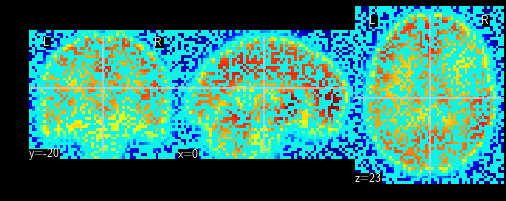

In [94]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

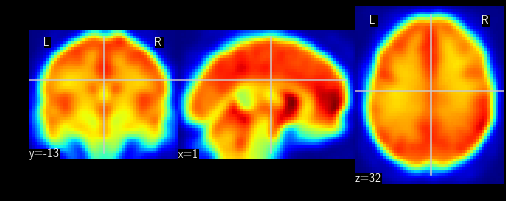

In [95]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

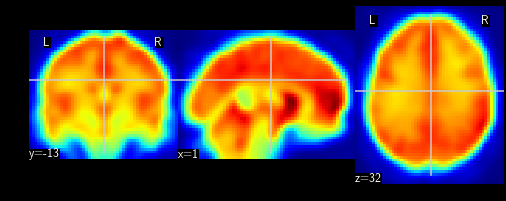

In [96]:
x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [97]:
images_folder = "/work/scratch/tt1/1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),x_hat, image.index_img(x_miss_img,1), "Rim Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/1/missing_ratio_60.00.png')
Called from mrd


In [98]:
estimated_val_img = mt.reconstruct_image_affine(x_true_org, estimated_val)

In [99]:
estimated_val_hat = image.index_img(estimated_val_img,1)

In [100]:
images_folder = "/work/scratch/tt1/2"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),estimated_val_hat,image.index_img(x_miss_img,1), "Rim Completion2",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/2/missing_ratio_60.00.png')
Called from mrd


In [101]:
def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score  

In [102]:
tsc_score = tsc(estimated_val,ground_truth_val, ten_ones, mask_indices)

In [103]:
tsc_score

0.003549233602623212